In [ ]:
!pip install langgraph langsmith langchain langchain_groq langchain_community arxiv wikipedia

In [3]:
from typing import Annotated
from typing_extensions import TypedDict

In [7]:
# Working with Tools
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

# Arxiv and Wikipedia tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results = 1, doc_content_chars = 1000)
arxiv_tool = ArxivQueryRun(api_wrapper = arxiv_wrapper)

wikipedia_wrapper = WikipediaAPIWrapper(top_k_results = 1, doc_content_chars = 1000)
wikipedia_tool = WikipediaQueryRun(api_wrapper = wikipedia_wrapper)

In [9]:
wikipedia_tool.invoke("Who is Anwar Ibrahim")

"Page: Anwar Ibrahim\nSummary: Anwar bin Ibrahim (Jawi: انور بن ابراهيم\u200e, IPA: Malay pronunciation: [anwar ɪbrahɪm] ; born 10 August 1947) is a Malaysian politician who has been the 10th and current Prime Minister of Malaysia since 2022. He served as the 12th and 16th Leader of the Opposition from 2008 to 2015, and again from 2020 to 2022. He has been the chairman of the Pakatan Harapan (PH) coalition since 2020, the second President of the People's Justice Party (PKR) since 2018 and the Member of Parliament (MP) for Tambun since November 2022. He also served as Deputy Prime Minister and in many other Cabinet positions in the Barisan Nasional (BN) administration under former Prime Minister Mahathir Mohamad from 1982 to his removal in 1998.\nA University of Malaya graduate, Anwar served as president of the National Union of Malaysian Muslim Students as well as Angkatan Belia Islam Malaysia (ABIM) or Muslim Youth Union of Malaysia before joining the United Malays National Organisati

In [10]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers."

In [11]:
tools = [wikipedia_tool, arxiv_tool]

In [12]:
from langgraph.graph.message import add_messages
# LangGraph application
class State(TypedDict):
  messages:Annotated[list, add_messages]

In [13]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

In [17]:
from google.colab import userdata
from langchain_groq import ChatGroq

groq_api_key = userdata.get('GROQ_API_KEY')
llm = ChatGroq(groq_api_key = groq_api_key, model = "Gemma2-9b-It")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x78a88ce2c070>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x78a88ce2ccd0>, model_name='Gemma2-9b-It', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [19]:
llm_with_tools = llm.bind_tools(tools=tools)

In [20]:
def chatbot(state:State):
  return {"messages" : [llm_with_tools.invoke(state["messages"])]}

In [21]:
from langgraph.prebuilt import ToolNode, tools_condition

# First para "chatbot" - node's name
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge("chatbot", END)

In [22]:
graph = graph_builder.compile()

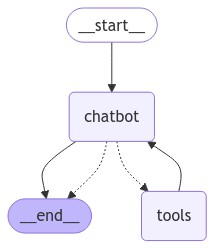

In [23]:
from IPython.display import Image, display_html
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [25]:
user_input = "Hi, there!, my name is Krish"

events = graph.stream(
  {"messages" : [("user", user_input)]},
  stream_mode = "values"
)

for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, there!, my name is Krish
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_7934)
 Call ID: call_7934
  Args:
    query: Krish


/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================

That's okay!  Is there anything else I can help you with?
